# Before begins

This notebook is written in google colab.

To see some interactive plots, please enter the colab link Below.

<a href="https://colab.research.google.com/drive/1n9XYmcvefp6rSD-rH7uZqfw3eVQ_cnxh?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# Overview
 

## Competition

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3948/logos/thumb76_76.png" width=40 align='left' alt="Open in Colab"/></a>
&nbsp; 
<font size="5">[Bike Sharing Demand](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)</font>: Forecast use of a city bikeshare system

## Notebook

This notebook provides the 'proper workflow' for kaggle submission.

The workflow is divided into three main steps.
1. Data preprocessing
2. Model selection (hyper parameter tuning, model combination, model comparison)
3. Training final model & Prediction on Test-set

At each stage, detailed descriptions of the work and an appropriate procedure will be provided.

Through this notebook, readers can learn the 'proper workflow' to be done for kaggle submission, 
and using this as a basic structure, someone will be able to apply this to other competitions easily with some adjustments

**Warnings**:
- The purpose of this notebook
  - This notebook focuses on the 'procedure' rather than the 'result'. 
  - Thus ths notebook does not guide you on how to achieve the top score. Since I personally think that any result can only have meaning through an appropriate procedure.
  - However, following this notebook, you will get the top 5% result in this competition

- The readers this notebook assumes
  - Who are aware of the basic usage of data processing tools (e.g., numpy, pandas)
  - Who are aware of the basic concepts of machine learning models 



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 0. Configuration

Set the configurations for this notebook

In [ ]:
config = {
    data_name: 'House_Price',
    random_state: 2022
}

# 1. Data preprocessing

The data preprocessing works are divided into 9 steps here.

Some of these steps are mandatory and some are optional.

Optional steps are marked separately.

It is important to go through each step in order.
Be careful not to reverse the order.

## 1-1. Load Dataset

Load train-set and test-set on working environment

In [ ]:
import numpy as np
import pandas as pd

train = pd.read_csv('/content/drive/MyDrive/Work/Kaggle/Data/{}/train.csv'.format(data_name))
test = pd.read_csv('/content/drive/MyDrive/Work/Kaggle/Data/{}/test.csv'.format(data_name))

### > Concatenate the 'train' and 'test' data for preprocessing

Data preprocessing work should be applied equally for train-set and test-set.

In order to work at once, exclude the response variable 'Survived' from 'train' and combine it with 'test'.

In [ ]:
all_features = pd.concat([train.drop(['casual', 'registered', 'count'], axis=1), test], axis=0)
y_train = train[['casual', 'registered', 'count']]

## 1-2. Missing Value Treatment

Missing (NA) values in Data must be treated properly before model training.

There are three main treatment methods:
1. Remove the variables which have NA values
2. Remove the rows (observations) which have NA values
3. Impute the NA values with other values

Which of the above methods is chosen depends on the analyst's discretion.
It is important to choose the appropriate method for the situation.

In [ ]:
all_features.isnull().sum()

array([0, 0, 0, 0, 0, 0, 0, 0, 0])

## 1-3. Variable modification

### datetime variable
필요한 정보
- year
- month 
- day
- hour
- name_of_day

In [ ]:
all_features['datetime'] = pd.to_datetime(all_features['datetime'])

all_features['year'] = all_features['datetime'].dt.year
all_features['month'] = all_features['datetime'].dt.month
all_features['day'] = all_features['datetime'].dt.day
all_features['hour'] = all_features['datetime'].dt.hour
all_features['day_name'] = all_features['datetime'].dt.day_name()

In [ ]:
all_features.drop(['datetime','day', 'day_name'], axis=1, inplace=True)

## 1-4. Variable transformation

### Input variable type transformation

In [ ]:
# int -> object
vars = ['season', 'holiday', 'workingday', 'weather', 'year', 'month', 'hour']
all_features[vars] = all_features[vars].astype(np.object)

In [ ]:
# int -> floate
vars = ['humidity']
all_features[vars] = all_features[vars].astype(np.float64)

### Output variable transformation

## 1-5. Dummify categorical variables

In the case of linear modeling without regularization, the first or last column should be dropped (to prevent linear dependency), but here, for the convenience of using the factorization model, one-hot encoding method is used that does not drop any columns.

In [ ]:
data_set = pd.get_dummies(all_features, drop_first=False)

## 1-6. Scaling continuous variables

Integer of float type variables are measured in different units (e.g., YearBuilt: by year, BsmfSF1: by square feet).

MinMaxScaling maps all variables from 0 to 1 in order to consider only relative information, not absolute magnitudes of the values.

Besides, it is known that scaling is often more stable in parameter optimization when training a model.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_set = scaler.fit_transform(data_set)

## 1-7. Split Train & Test set

In [ ]:
n_train = train.shape[0]
X_train = data_set[:n_train].astype(np.float32)
X_test = data_set[n_train:].astype(np.float32)
y_train = y_train.astype(np.float32)

## 1-8. Outlier Detection (*optional*)

Detect and remove outlier observations that exist in the train-set.

- Methodology: [Isolation Forest](https://ieeexplore.ieee.org/abstract/document/4781136/?casa_token=V7U3M1UIykoAAAAA:kww9pojtMeJtXaBcNmw0eVlJaXEGGICi1ogmeHUFMpgJ2h_XCbSd2yBU5mRgd7zEJrXZ01z2)
  - How it works
    - Isolation Forest applies a decision tree that repeats splits based on the 'random criterion' for the given data unitl only one observation remains in every terminal node (this is defined as 'isolation').
    - Based on the number of splits used for isolation, 'normality' is defined. A smaller value means a higher degree of outlierness.
    - By applying this decision tree several times, the average of the measured 'normality' values ​​is derived as the final 'normality' value.
  - Assumptions
    - Outliers require relatively few splits to be isolated.
    - For normal data, the number of splits required to be isolated is relatively large.
  - Outlier determination
    - Determines whether it is an outlier or not based on the measured 'normality' value.
      - sklearn's IsolationForest package determines based on '0' 
      - I, personally, think it is better to set the discriminant criterion by considering the 'distribution' of the 'normality' values.
      - The details of the method is given below.

In [ ]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(
    n_estimators=100,
    max_samples='auto',
    n_jobs=-1,
    random_state=random_state)

clf.fit(X_train)
normality = clf.decision_function(X_train)

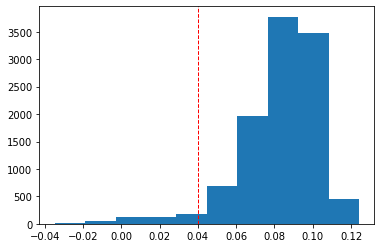

In [ ]:
import matplotlib.pyplot as plt

k = 1.5
q1 = np.quantile(clf.decision_function(X_train), 0.25)
q3 = np.quantile(clf.decision_function(X_train), 0.75)
threshold = q1 - k*(q3-q1)

_ = plt.hist(normality)
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=1)

In [ ]:
import plotly.express as px
px.box(normality_df, x='normality', orientation='h', width=400, height=400)

In [ ]:
X_train = X_train[normality_df['normality'].values>=threshold]
y_train = y_train[normality_df['normality'].values>=threshold]

print('{} observations are removed from train_set'.format(train.shape[0] - X_train.shape[0]))

# 2. Model Selection

Our goal is to build a model that predicts the expected value of the sale price (y) of a house by using informations about the house (x). The formula can be expressed as:

$E[y_{i}|X=x_{i}]$

This is a typical regression problem, and various machine learning models can be used. This notebook uses the following models.
- (Regularized) Linear regression
- Support vector machine
- Random forest
- Xgboost
- Multi-layer perceptron
- Factorization

However, we have to "choose" one final methodology to make predictions on the test set.
To do this, a “fair evaluation” of the models is essential. "Fair evaluation" must satisfy the following two conditions.

1. Select optimal hyperparameters for each model
  - If hyperparameter search is not performed, the difference in model performance may occur due to incorrect hyperparameter values.
2. same evaluation method
  - If the same evaluation method is not applied, comparison between models itself is impossible.

When comparing models through an evaluation method that satisfies the above two conditions,
Only then can the final model be selected.




### > Install Packages

In [ ]:
! pip install tune_sklearn ray[tune] skorch

## 2-1. Response variable consideration

In [ ]:
y_train_two = y_train[['casual', 'registered']].values.astype(np.float32)
y_train_count = y_train['count'].values.astype(np.float32)

y_train_two_trans = np.log1p(y_train_two)

### > Define a scoring function for hyper parameter tuning


In [ ]:
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

def neg_rmsle_custom(y_true_two_trans, y_pred_two):
  score = np.negative(mean_squared_error(np.log1p(np.expm1(y_true_two_trans).sum(axis=1)), 
                                         np.log1p(np.expm1(np.maximum(y_pred_two, 0)).sum(axis=1)), squared=False))
  return score

target_metric = make_scorer(neg_rmsle_custom, greater_is_better=True)

## 2-1. Hyper parameter tuning by using Tune_SKlearn (Ray Tune)

- Package: tune_sklearn
  - This package makes it easy to apply [Ray Tune](https://docs.ray.io/en/latest/tune/index.html) to sklearn models.
  - Ray Tune is a python package that provides various hyperparameter tuning algorithms (HyperOpt, BayesianOptimization, ...).
- Tuning procedure
  - Define an appropriate search space for each model's hyperparameters.
  - 5-fold CV (Cross Validation) is performed for each specific hyper-parameter value combination of the search space by using the hyper-parameter tuning algorithm (HyperOpt)
    - Training: Training by using Scikit-Learn and Skorch packages
    - Validation: Evaluate the model using an appropriate evaluation metric
  - The hyperparameter with the highest average score of the CV result is designated as the optimal hyperparameter of the model.
    - Save this CV result and use for model comparison



In [ ]:
model_list = []
best_hyper_param_list = []
for name in ['linear', 'svm', 'rf', 'xgb', 'mlp', 'fm']:
  model_list.append(np.full(5, name))
  best_hyper_param_list.append(name)
  
best_cv_df = pd.DataFrame({'model': np.hstack((model_list)), 'RMSLE':None})
best_hyper_param_df = pd.DataFrame({'model': best_hyper_param_list, 'best_hyper_param':None})

### Linear regression

In [ ]:
from tune_sklearn import TuneSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import SGDRegressor


parameters = {
    'estimator__alpha': list(np.geomspace(1e-10, 1e-6, 5)),
    'estimator__max_iter': [5000],
    'estimator__tol': [1e-3],
    'estimator__loss': ['squared_error'],
    'estimator__penalty': ['l2'],
    'estimator__early_stopping': [True],
    'estimator__validation_fraction': [0.1],
    'estimator__n_iter_no_change': [5],        
    'estimator__random_state': [random_state]
}

base_regr = SGDRegressor()
regressor = MultiOutputRegressor(base_regr)

tune_search = TuneSearchCV(
    regressor,
    parameters,
    search_optimization='hyperopt',
    # early_stopping=True,
    # max_iters=10,
    n_trials=5,
    n_jobs=-1,
    scoring={'RMSLE':target_metric},
    cv=5,
    refit='RMSLE',
    verbose=1,
    random_state=random_state
    )

tune_search.fit(X_train, y_train_two_trans)

model_name = 'linear'

best_hyper_param_df.loc[best_hyper_param_df['model']==model_name,'best_hyper_param'] = str(tune_search.best_params_)

cv_df = pd.DataFrame(tune_search.cv_results_)
cv_values = cv_df.loc[tune_search.best_index_, cv_df.columns.str.startswith('split')].values
best_cv_df.loc[best_cv_df['model']==model_name, 'RMSLE'] = cv_values[:5]

tune_result_df = pd.concat([pd.DataFrame(tune_search.cv_results_['params']), cv_df.loc[:,cv_df.columns.str.startswith('mean')] ], axis=1)
import plotly.express as px
px.parallel_coordinates(tune_result_df, color='mean_test_RMSLE')

### Support vector machine

In [ ]:
from tune_sklearn import TuneSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.multioutput import MultiOutputRegressor

parameters = {
    'estimator__alpha': list(np.geomspace(1e-7, 1e-3, 3)),
    'estimator__epsilon': list(np.geomspace(1e-5, 1e-1, 3)),
    'estimator__loss': ['huber', 'epsilon_insensitive'],
    'estimator__tol': [1e-3],
    'estimator__max_iter': [5000],
    'estimator__penalty': ['l2'],
    'estimator__early_stopping': [True],
    'estimator__validation_fraction': [0.1],
    'estimator__n_iter_no_change': [5],          
    'estimator__random_state': [random_state]
}

base_regr = SGDRegressor()
regressor = MultiOutputRegressor(base_regr)

tune_search = TuneSearchCV(
    regressor,
    parameters,
    # early_stopping=True,
    # max_iters=10,
    search_optimization='hyperopt',
    n_trials=10,
    n_jobs=-1,
    scoring={'RMSLE': target_metric},
    cv=5,
    refit='RMSLE',
    verbose=1,
    random_state=random_state
    )

tune_search.fit(X_train, y_train_two_trans)

model_name = 'svm'

best_hyper_param_df.loc[best_hyper_param_df['model']==model_name,'best_hyper_param'] = str(tune_search.best_params_)

cv_df = pd.DataFrame(tune_search.cv_results_)
cv_values = cv_df.loc[tune_search.best_index_, cv_df.columns.str.startswith('split')].values
best_cv_df.loc[best_cv_df['model']==model_name, 'RMSLE'] = cv_values[:5]

tune_result_df = pd.concat([pd.DataFrame(tune_search.cv_results_['params']), cv_df.loc[:,cv_df.columns.str.startswith('mean')] ], axis=1)
import plotly.express as px
px.parallel_coordinates(tune_result_df, color='mean_test_RMSLE')

### Random forest

In [ ]:
from tune_sklearn import TuneGridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

parameters = {
    'estimator__n_estimators': [100, 300],
    'estimator__criterion': ['squared_error'],
    'estimator__max_depth': [20, 25, 30],
    'estimator__max_features': ['auto'],
    'estimator__random_state': [random_state]
}

base_regr = RandomForestRegressor()
regressor = MultiOutputRegressor(base_regr)

tune_search = TuneSearchCV(
    regressor,
    parameters,
    # early_stopping=True,
    # max_iters=10,
    search_optimization='hyperopt',
    n_trials=15,
    n_jobs=-1,
    scoring={'RMSLE': target_metric},
    cv=5,
    refit='RMSLE',
    verbose=1,
    random_state=random_state
    )


X = X_train
y = y_train_two_trans

tune_search.fit(X, y)

model_name = 'rf'

best_hyper_param_df.loc[best_hyper_param_df['model']==model_name,'best_hyper_param'] = str(tune_search.best_params_)

cv_df = pd.DataFrame(tune_search.cv_results_)
cv_values = cv_df.loc[tune_search.best_index_, cv_df.columns.str.startswith('split')].values
best_cv_df.loc[best_cv_df['model']==model_name, 'RMSLE'] = cv_values[:5]

tune_result_df = pd.concat([pd.DataFrame(tune_search.cv_results_['params']), cv_df.loc[:,cv_df.columns.str.startswith('mean')] ], axis=1)
import plotly.express as px
px.parallel_coordinates(tune_result_df, color='mean_test_RMSLE')

### XGBoost

In [ ]:
from tune_sklearn import TuneSearchCV
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

parameters = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__learning_rate': [0.01, 0.1, 0.2],
    'estimator__min_child_weight': [5, 10, 15],
    'estimator__gamma': list(np.geomspace(1e-2, 1, 3)),
    'estimator__subsample': [0.6, 1.0],
    'estimator__colsample_bytree': [0.6, 1.0],
    'estimator__max_depth': [15, 20, 25],
    'estimator__objective': ['reg:squarederror'],
    'estimator__random_state': [random_state]
}

base_regr = XGBRegressor()
regressor = MultiOutputRegressor(base_regr)

tune_search = TuneSearchCV(
    regressor,
    parameters,
    # early_stopping=True,
    # max_iters=10,
    search_optimization='hyperopt',
    n_trials=15,
    n_jobs=-1,
    scoring={'RMSLE': target_metric},
    cv=5,
    refit='RMSLE',
    verbose=1,
    random_state=random_state
    )

X = X_train
y = y_train_two_trans


tune_search.fit(X, y)

model_name = 'xgb'

best_hyper_param_df.loc[best_hyper_param_df['model']==model_name,'best_hyper_param'] = str(tune_search.best_params_)

cv_df = pd.DataFrame(tune_search.cv_results_)
cv_values = cv_df.loc[tune_search.best_index_, cv_df.columns.str.startswith('split')].values
best_cv_df.loc[best_cv_df['model']==model_name, 'RMSLE'] = cv_values[:5]

tune_result_df = pd.concat([pd.DataFrame(tune_search.cv_results_['params']), cv_df.loc[:,cv_df.columns.str.startswith('mean')] ], axis=1)
import plotly.express as px
px.parallel_coordinates(tune_result_df, color='mean_test_RMSLE')

### Multi-layer perceptron

In [ ]:
import torch
from torch import nn
from skorch.regressor import NeuralNetRegressor
from skorch.callbacks import EarlyStopping
from skorch.callbacks import EpochScoring
from skorch.callbacks import Checkpoint
from tune_sklearn import TuneSearchCV
from sklearn.multioutput import MultiOutputRegressor


class MLP(nn.Module):
    def __init__(self, num_inputs=X_train.shape[1], num_outputs=2, layer1=512, layer2=256, dropout1=0, dropout2=0):
        super(MLP, self).__init__()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(num_inputs, layer1),
            nn.LeakyReLU(),
            nn.Dropout(dropout1),
            nn.Linear(layer1, layer2),
            nn.LeakyReLU(),
            nn.Dropout(dropout2),
            nn.Linear(layer2, num_outputs)
            )
    def forward(self, x):
        x = self.linear_relu_stack(x)
        return x  

def try_gpu(i=0): 
    return f'cuda:{i}' if torch.cuda.device_count() >= i + 1 else 'cpu'

mlp = NeuralNetRegressor(
    MLP(num_inputs=X_train.shape[1], num_outputs=2),
    optimizer=torch.optim.Adam,
    criterion=nn.MSELoss,
    iterator_train__shuffle=True,
    device=try_gpu(),
    verbose=0,
    max_epochs=1000,
    callbacks=[EpochScoring(target_metric, lower_is_better=False, on_train=False, name='valid_neg_rmsle'),
               EarlyStopping(monitor='valid_neg_rmsle', patience=5,
                             threshold=1e-3, lower_is_better=False),
               Checkpoint(monitor='valid_neg_rmsle_best')]
                          )

parameters = {
    'lr': list(np.geomspace(1e-5, 1e-2, 4)),
    'module__layer1': [128, 256],
    'module__layer2': [128, 256],
    'module__dropout1': [0, 0.1],
    'module__dropout2': [0, 0.1],
    'optimizer__weight_decay': list(np.append(0, np.geomspace(1e-6, 1e-1, 6))),
    'max_epochs': [1000],
    'batch_size': [128],
    'callbacks__EarlyStopping__threshold': [1e-3]
    }

def use_gpu(device):
    return True if not device == 'cpu' else False 


tune_search = TuneSearchCV(
    mlp,
    parameters,
    # early_stopping=True,
    # max_iters=10,
    search_optimization='hyperopt',
    n_trials=15,
    n_jobs=-1,
    scoring={'RMSLE': target_metric},
    cv=5,
    refit='RMSLE',
    verbose=1,
    random_state=random_state
    )

X = X_train
y = y_train_two_trans

tune_search.fit(X, y)

model_name = 'mlp'

best_hyper_param_df.loc[best_hyper_param_df['model']==model_name,'best_hyper_param'] = str(tune_search.best_params_)

cv_df = pd.DataFrame(tune_search.cv_results_)
cv_values = cv_df.loc[tune_search.best_index_, cv_df.columns.str.startswith('split')].values
best_cv_df.loc[best_cv_df['model']==model_name, 'RMSLE'] = cv_values[:5]

tune_result_df = pd.concat([pd.DataFrame(tune_search.cv_results_['params']), cv_df.loc[:,cv_df.columns.str.startswith('mean')] ], axis=1)
tune_result_df.rename({
    'callbacks__EarlyStopping__threshold':'Earlystoping_threshold',
    'optimizer__weight_decay': 'weight_decay'
    }, axis=1, inplace=True)
import plotly.express as px
px.parallel_coordinates(tune_result_df, color='mean_test_RMSLE')

### Factorization Machine

In [ ]:
def prepro_for_fm(X_train, X_test, num_cont_dims):
  n_train = X_train.shape[0]
  all = np.vstack((X_train, X_test))
  all_cont = all[:,:num_cont_dims]
  all_dis = all[:,num_cont_dims:]
  
  for i in range(num_cont_dims):
    # bin_size = len(np.histogram(all_cont[:,i], bins='auto')[0])
    bin_size = 10
    all_cont[:,i] = pd.cut(all_cont[:,i], bins=bin_size, labels=False)

  all_cont_df = pd.DataFrame(all_cont).astype('category')
  all_cont_array = pd.get_dummies(all_cont_df, drop_first=False).to_numpy()

  all_array = np.hstack((all_cont_array, all_dis)).astype(np.int64)
  field_dims = all_array.shape[1]
  all_fm = np.vstack((np.apply_along_axis(lambda x: np.where(x==1), 1, all_array)))

  return all_fm[:n_train], all_fm[n_train:], field_dims


num_cont_dims = (pd.get_dummies(all_features).dtypes != np.uint8).values.sum()

X_train_fm, X_test_fm, field_dims = prepro_for_fm(X_train, X_test, num_cont_dims)  

In [ ]:
import torch
from torch import nn
from skorch.regressor import NeuralNetRegressor
from skorch.callbacks import EarlyStopping
from skorch.callbacks import EpochScoring
from skorch.callbacks import Checkpoint
from tune_sklearn import TuneSearchCV
from sklearn.multioutput import MultiOutputRegressor

class FM(nn.Module):
    def __init__(self, num_inputs=field_dims, num_factors=20, output_dim=2):
        super(FM, self).__init__()
        self.embedding_1 = nn.Embedding(num_inputs, num_factors)
        self.embedding_2 = nn.Embedding(num_inputs, num_factors)
        self.fc = nn.Embedding(num_inputs, output_dim)
        self.bias = nn.Parameter(torch.zeros((output_dim,)))
        self.relu = nn.ReLU()

    def forward(self, x):
        square_of_sum_1 = torch.sum(self.embedding_1(x), dim=1)**2
        square_of_sum_2 = torch.sum(self.embedding_2(x), dim=1)**2
        square_of_sum = torch.stack([square_of_sum_1, square_of_sum_2], dim=1)

        sum_of_square_1 = torch.sum(self.embedding_1(x)**2, dim=1)
        sum_of_square_2 = torch.sum(self.embedding_2(x)**2, dim=1)
        sum_of_square = torch.stack([sum_of_square_1, sum_of_square_2], dim=1)

        x = self.bias + self.fc(x).sum(dim=1) + 0.5 * (square_of_sum - sum_of_square).sum(dim=2)
        return x 

def try_gpu(i=0): 
    return f'cuda:{i}' if torch.cuda.device_count() >= i + 1 else 'cpu'

fm = NeuralNetRegressor(
    FM(num_inputs=field_dims, num_factors=20, output_dim=2),
    optimizer=torch.optim.Adam,
    criterion=nn.MSELoss,
    iterator_train__shuffle=True,
    device=try_gpu(),
    verbose=0,
    callbacks=[EpochScoring(target_metric, lower_is_better=False, on_train=False, name='valid_neg_rmsle'),
               EarlyStopping(monitor='valid_neg_rmsle', patience=5,
                             threshold=1e-3, lower_is_better=False),
               Checkpoint(monitor='valid_neg_rmsle_best')]
                          )

parameters = {
    'lr': list(np.geomspace(1e-3, 1e-1, 3)),
    'module__num_factors': [10, 20],
    'optimizer__weight_decay': [0.005, 0.01, 0.05],
    'max_epochs': [1000],
    'batch_size': [128, 256],
    'callbacks__EarlyStopping__threshold': [1e-3]
    }

def use_gpu(device):
    return True if not device == 'cpu' else False 

# base_regr = fm
# regressor = MultiOutputRegressor(base_regr)

tune_search = TuneSearchCV(
    fm,
    parameters,
    search_optimization='hyperopt',
    n_trials=10,
    n_jobs=-1,
    scoring={'RMSLE': target_metric},
    cv=5,
    refit='RMSLE',
    verbose=1,
    random_state=random_state
    )


X = X_train_fm
y = y_train_two_trans

tune_search.fit(X, y)

model_name = 'fm'

best_hyper_param_df.loc[best_hyper_param_df['model']==model_name,'best_hyper_param'] = str(tune_search.best_params_)

cv_df = pd.DataFrame(tune_search.cv_results_)
cv_values = cv_df.loc[tune_search.best_index_, cv_df.columns.str.startswith('split')].values
best_cv_df.loc[best_cv_df['model']==model_name, 'RMSLE'] = cv_values[:5]

tune_result_df = pd.concat([pd.DataFrame(tune_search.cv_results_['params']), cv_df.loc[:,cv_df.columns.str.startswith('mean')] ], axis=1)
import plotly.express as px
px.parallel_coordinates(tune_result_df, color='mean_test_RMSLE')

In [ ]:
data_name = 'Bike_Sharing'

best_cv_df.to_csv('/content/drive/MyDrive/Work/Kaggle/Result/{}/best_cv_results.csv'.format(data_name), index=False)
best_hyper_param_df.to_csv('/content/drive/MyDrive/Work/Kaggle/Result/{}/best_hyper_param.csv'.format(data_name), index=False)

## 2-2. Model comparison based on CV results with best hyper parameters

Compare the CV results (measured using the optimal hyper parameter values)

The figure below shows that the rf, xgb, mlp, and fm models show superior performance compared to the linear and svm models.



In [ ]:
data_name = 'Bike_Sharing'
best_cv_df = pd.read_csv('/content/drive/MyDrive/Work/Kaggle/Result/{}/best_cv_results.csv'.format(data_name))
best_hyper_param_df = pd.read_csv('/content/drive/MyDrive/Work/Kaggle/Result/{}/best_hyper_param.csv'.format(data_name))

In [ ]:
fig = px.box(best_cv_df, x='model', y='RMSLE', color='model', width=600)
fig.show()

## 2-3. Model Combination

Although it is possible to select a final model based on the above results, it has been observed that in many cases the combination of predicted values ​​from multiple models leads to improve prediction performance. ([Can multi-model combination really enhance the prediction skill of probabilistic ensemble forecasts?](https://rmets.onlinelibrary.wiley.com/doi/abs/10.1002/qj.210?casa_token=OwyF2RbEywAAAAAA:gahpwGRdOWzLXyafYQQt_voHOF8MedTBLd1SBv4vkdT3ZTLVoKZQj3zl-KbrhSkX5x8CndeCxwBoL_-S))

For classification problems, the final probabilities are derived by combining the predicted 'probabilities' for each class in a 'proper way'.

This notebook uses following two model combination methods.

1. Simple Average
2. Stacked Generalization (Stacking)


Model comparison needs to be compared with single models (e.g., rf, xgb,...).
So model performance are measured by applying the same CV method as above.

### > Simple Average

The simple average method derives the final probability value by 'averaging' the predicted probability values ​​for each class of multiple models.

The top 4 models (rf, xgb, mlp, fm) of the above CV results are selected as base estimators used for the combination of predicted values.

For example,
- Base Estimations
  - $P_{rf}(Y=1|X=x)$ = 0.75
  - $P_{xgb}(Y=1|X=x)$ = 0.80
  - $P_{mlp}(Y=1|X=x)$ = 0.85
  - $P_{fm}(Y=1|X=x)$ = 0.80
- Final Estimation
  - $P_{average}(Y=1|X=x)$  = 0.8 (= 0.75 + 0.80 + 0.85 + 0.80 / 4)


In [ ]:
from sklearn.model_selection import KFold
from tqdm import notebook
from sklearn.metrics import mean_squared_error

def CV_ensemble(ensemble_name, ensemble_func, estimators, X_train, y_train, n_folds=5, shuffle=True, random_state=2022):
  kf = KFold(n_splits=5, random_state=random_state, shuffle=True)

  res_list = []
  for train_idx, valid_idx in notebook.tqdm(kf.split(X_train), total=kf.get_n_splits(), desc='Eval_CV'):
    X_train_train, X_valid = X_train[train_idx], X_train[valid_idx]
    y_train_train, y_valid = y_train[train_idx], y_train[valid_idx]

    ensemble_pred = ensemble_func(estimators, X_train_train, y_train_train, X_valid)
    neg_rmsle = neg_rmsle_custom(y_valid, ensemble_pred)

    res_list.append([ensemble_name, neg_rmsle])
  res_df = pd.DataFrame(np.vstack((res_list)))
  res_df.columns = ['model', 'RMSLE']
  return res_df

def average_reg_multi_output(estimators, X_train, y_train, X_test):
  preds = []
  for iter in range(len(estimators)):
    try:
      estimators[iter].module__num_factors
    except: # for other models
      estimators[iter].fit(X_train, y_train)
      preds.append([estimators[iter].predict(X_test)])
    else: # for factorization machine
      X_train_fm, X_test_fm, _ = prepro_for_fm(X_train, X_test, num_cont_dims)
      estimators[iter].fit(X_train_fm, y_train)
      preds.append([estimators[iter].predict(X_test_fm)])
    
  avg_pred = np.vstack((preds)).mean(axis=0)
  return avg_pred

In [ ]:
import torch
from torch import nn
from skorch.regressor import NeuralNetRegressor
from skorch.callbacks import EarlyStopping


class MLP(nn.Module):
    def __init__(self, num_inputs=X_train.shape[1], num_outputs=2, layer1=512, layer2=256, dropout1=0, dropout2=0):
        super(MLP, self).__init__()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(num_inputs, layer1),
            nn.LeakyReLU(),
            nn.Dropout(dropout1),
            nn.Linear(layer1, layer2),
            nn.LeakyReLU(),
            nn.Dropout(dropout2),
            nn.Linear(layer2, num_outputs)
            )
    def forward(self, x):
        x = self.linear_relu_stack(x)
        return x  


class FM(nn.Module):
    def __init__(self, num_inputs=100, num_factors=20, output_dim=2):
        super(FM, self).__init__()
        self.embedding_1 = nn.Embedding(num_inputs, num_factors)
        self.embedding_2 = nn.Embedding(num_inputs, num_factors)
        self.fc = nn.Embedding(num_inputs, output_dim)
        self.bias = nn.Parameter(torch.zeros((output_dim,)))
        self.relu = nn.ReLU()

    def forward(self, x):
        square_of_sum_1 = torch.sum(self.embedding_1(x), dim=1)**2
        square_of_sum_2 = torch.sum(self.embedding_2(x), dim=1)**2
        square_of_sum = torch.stack([square_of_sum_1, square_of_sum_2], dim=1)

        sum_of_square_1 = torch.sum(self.embedding_1(x)**2, dim=1)
        sum_of_square_2 = torch.sum(self.embedding_2(x)**2, dim=1)
        sum_of_square = torch.stack([sum_of_square_1, sum_of_square_2], dim=1)

        x = self.bias + self.fc(x).sum(dim=1) + 0.5 * (square_of_sum - sum_of_square).sum(dim=2)
        return x 

def try_gpu(i=0): 
    return f'cuda:{i}' if torch.cuda.device_count() >= i + 1 else 'cpu'

def prepro_for_fm(X_train, X_test, num_cont_dims):
  n_train = X_train.shape[0]
  all = np.vstack((X_train, X_test))
  all_cont = all[:,:num_cont_dims]
  all_dis = all[:,num_cont_dims:]
  
  for i in range(num_cont_dims):
    # bin_size = len(np.histogram(all_cont[:,i], bins='auto')[0])
    bin_size = 10
    all_cont[:,i] = pd.cut(all_cont[:,i], bins=bin_size, labels=False)

  all_cont_df = pd.DataFrame(all_cont).astype('category')
  all_cont_array = pd.get_dummies(all_cont_df, drop_first=False).to_numpy()

  all_array = np.hstack((all_cont_array, all_dis)).astype(np.int64)
  field_dims = all_array.shape[1]
  all_fm = np.vstack((np.apply_along_axis(lambda x: np.where(x==1), 1, all_array)))

  return all_fm[:n_train], all_fm[n_train:], field_dims


num_cont_dims = (pd.get_dummies(all_features).dtypes != np.uint8).values.sum()
X_train_fm, X_test_fm, field_dims = prepro_for_fm(X_train, X_test, num_cont_dims)  



mlp = NeuralNetRegressor(
    MLP(num_inputs=X_train.shape[1], num_outputs=2),
    optimizer=torch.optim.Adam,
    criterion=nn.MSELoss,
    iterator_train__shuffle=True,
    device=try_gpu(),
    verbose=0,
    callbacks=[EarlyStopping(monitor='valid_loss', patience=5,
                             threshold=1e-3, lower_is_better=True)]
                          )

fm = NeuralNetRegressor(
    FM(num_inputs=field_dims, num_factors=20, output_dim=2),
    optimizer=torch.optim.Adam,
    criterion=nn.MSELoss,
    iterator_train__shuffle=True,
    device=try_gpu(),
    verbose=0,
    callbacks=[EarlyStopping(monitor='valid_loss', patience=5,
                             threshold=1e-3, lower_is_better=True)]
                          )


In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

linear = MultiOutputRegressor(SGDRegressor()).set_params(**eval(best_hyper_param_df.iloc[0,1]))
svm = MultiOutputRegressor(SGDRegressor()).set_params(**eval(best_hyper_param_df.iloc[1,1]))
rf = MultiOutputRegressor(RandomForestRegressor()).set_params(**eval(best_hyper_param_df.iloc[2,1]))
xgb = MultiOutputRegressor(XGBRegressor()).set_params(**eval(best_hyper_param_df.iloc[3,1]))

mlp = mlp.set_params(**eval(best_hyper_param_df.iloc[4,1]))
fm = fm.set_params(**eval(best_hyper_param_df.iloc[5,1]))

estimators = [xgb, mlp, fm]

ensemble_name = 'average'
ensemble_func = average_reg_multi_output
X = X_train
y = y_train_two_trans

res_df = CV_ensemble(ensemble_name, ensemble_func, estimators, X, y, n_folds=5, shuffle=True, random_state=random_state)
best_cv_df = best_cv_df.append(res_df).reset_index(drop=True)

Eval_CV:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memor

In [ ]:
fig = px.box(best_cv_df, x='model', y='RMSLE', color='model', width=600)
fig.show()

In [ ]:
data_name = 'Bike_Sharing'

best_cv_df.to_csv('/content/drive/MyDrive/Work/Kaggle/Result/{}/best_cv_results.csv'.format(data_name), index=False)
best_hyper_param_df.to_csv('/content/drive/MyDrive/Work/Kaggle/Result/{}/best_hyper_param.csv'.format(data_name), index=False)

### > Stacked generalization (Stacking)

In the [Stacked generalization](https://www.jair.org/index.php/jair/article/view/10228), the predicted probabilities for each class of base estimators are treated as the 'input data', and the result obtained by fitting the 'Meta Learner' with y of each row as the response variable is derived as the final probability.

- The 'Meta Learner' can be used with any of the binary classification models. However, this notebook uses a ridge model (logistic regression with ridge penalty) to prevent overfitting.

- As input data for 'Meta Learner', prediction probabilities for validation data in cv of base estimators are obtained.

- Trained meta-learner predicts the final predicted probabilities for the test-set by using the predicted probabilites of baes estimators for the test-set as input data.

The total process, in order, is as follows:
1. (Base estimators) Run CV on Train-set
2. (Meta Learner) Train on CV predictions (predicted probabilities on validation data of CV) with corresponding y values
3. (Base estimators) Train on Train-set
4. (Base estimators) Predict on Test-set
5. (Meta Learner) Predict on predictions on Test-set

<img align='top' src='https://drive.google.com/uc?export=view&id=1uDxSIIFt8rUJkuIwRYU4lALvOPqlXPG5' width='600' height='400'>


For example,
- Base Estimations
  - $P_{rf}(Y=1|X=x)$ = 0.75
  - $P_{xgb}(Y=1|X=x)$ = 0.80
  - $P_{mlp}(Y=1|X=x)$ = 0.85
  - $P_{fm}(Y=1|X=x)$ = 0.80
- Meta Learner (logistic regression)
  - Parameter
    - intercept = 0.1
    - coefficient = [0.2, 0.9, 0.8, 0.3]
  - $P_{stack}(Y=1|X=x) = 0.8442 = sigmoid(-0.1 + 0.2*0.75 + 0.9*0.80 + 0.8*0.85 + 0.3*0.80)$

In [ ]:
from sklearn.model_selection import KFold
from tqdm import notebook

def stack_reg_multi_output(estimators, X_train, y_train, X_test, n_folds=5, shuffle=True, random_state=random_state):
  num_estimators = len(estimators)-1
  num_output = y_train.shape[1]

  final_estimator = estimators[-1]
  kf = KFold(n_splits=n_folds, random_state=random_state, shuffle=shuffle)
  preds = []
  y_valid_list = []
  # Get CV predictions
  for train_idx, valid_idx in notebook.tqdm(kf.split(X_train), total=kf.get_n_splits(), desc='Stack_CV'):
    X_train_train, X_valid = X_train[train_idx], X_train[valid_idx]
    y_train_train, y_valid = y_train[train_idx], y_train[valid_idx]
    
    valid_preds = []
    for iter in range(num_estimators):
      try:
        estimators[iter].module__num_factors
      except: # for other models
        estimators[iter].fit(X_train_train, y_train_train)
        valid_preds.append([estimators[iter].predict(X_valid)])
      else: # for factorization machine
        X_train_train_fm, X_valid_fm, _ = prepro_for_fm(X_train_train, X_valid, num_cont_dims)
        estimators[iter].fit(X_train_train_fm, y_train_train)
        valid_preds.append([estimators[iter].predict(X_valid_fm)])
    
    preds.append(np.hstack((np.vstack((valid_preds)))))
    y_valid_list.append(y_valid)

  cv_preds = np.vstack((preds))
  cv_y = np.vstack((y_valid_list))
  
  # Get test predictions
  test_preds =[]
  for iter in range(num_estimators):
    try:
      estimators[iter].module__num_factors
    except: # for other models
      estimators[iter].fit(X_train, y_train)
      test_preds.append([estimators[iter].predict(X_test)])
    else: # for factorization machine
      X_train_fm, X_test_fm, _ = prepro_for_fm(X_train, X_test, num_cont_dims)    
      estimators[iter].fit(X_train_fm, y_train)
      test_preds.append([estimators[iter].predict(X_test_fm)])

  test_preds_mat = np.hstack((np.vstack((test_preds))))

  # Fit the final estimator on prediction values
  final_estimator.fit(cv_preds, cv_y)
  print('Training RMSLE: {}'.format(target_metric(final_estimator, cv_preds, cv_y)))
  for iter in range(num_output):
    print('Estimated coefficients of model {}: {} \n intercept: {}'.format(iter, final_estimator.estimators_[iter].coef_, 
                                                                           final_estimator.estimators_[iter].intercept_))
  test_ensemble_pred = final_estimator.predict(test_preds_mat)
  return test_ensemble_pred

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

linear = MultiOutputRegressor(SGDRegressor()).set_params(**eval(best_hyper_param_df.iloc[0,1]))
svm = MultiOutputRegressor(SGDRegressor()).set_params(**eval(best_hyper_param_df.iloc[1,1]))
rf = MultiOutputRegressor(RandomForestRegressor()).set_params(**eval(best_hyper_param_df.iloc[2,1]))
xgb = MultiOutputRegressor(XGBRegressor()).set_params(**eval(best_hyper_param_df.iloc[3,1]))

mlp = mlp.set_params(**eval(best_hyper_param_df.iloc[4,1]))
fm = fm.set_params(**eval(best_hyper_param_df.iloc[5,1]))

reg = MultiOutputRegressor(LinearRegression())
# reg = Ridge()

estimators = [xgb, mlp, fm, reg]

ensemble_name = 'stack_linear'
ensemble_func = stack_reg_multi_output
X = X_train
y = y_train_two_trans

res_df = CV_ensemble(ensemble_name, ensemble_func, estimators, X, y, n_folds=5, shuffle=True, random_state=random_state)
best_cv_df = best_cv_df.append(res_df).reset_index(drop=True)

Eval_CV:   0%|          | 0/5 [00:00<?, ?it/s]

Stack_CV:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memor

Training RMSLE: -0.3082531690597534
Estimated coefficients of model 0: [ 0.4347051   0.21213388  0.37145633 -0.21187787  0.19321461  0.01470135] 
 intercept: -0.09607505798339844
Estimated coefficients of model 1: [ 0.06070635  0.52578026 -0.02595812  0.2506917  -0.02751169  0.24388622] 
 intercept: -0.12970829010009766


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



Stack_CV:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memor

Training RMSLE: -0.3135293126106262
Estimated coefficients of model 0: [ 0.4298564   0.22036195  0.3603369  -0.19823547  0.2061772  -0.00417741] 
 intercept: -0.07778382301330566
Estimated coefficients of model 1: [ 0.06236656  0.544021   -0.09219781  0.35545647  0.03927314  0.11314534] 
 intercept: -0.10628747940063477


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



Stack_CV:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memor

Training RMSLE: -0.3134641647338867
Estimated coefficients of model 0: [ 0.43502402  0.21185985  0.4481661  -0.25354898  0.1172166   0.05922969] 
 intercept: -0.09151411056518555
Estimated coefficients of model 1: [ 0.06383492  0.52719563 -0.08647686  0.30848202  0.03063369  0.18351042] 
 intercept: -0.13333749771118164


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



Stack_CV:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memor

Training RMSLE: -0.31338784098625183
Estimated coefficients of model 0: [ 0.3942094   0.27262735  0.46662784 -0.28834724  0.14176351  0.03123029] 
 intercept: -0.08986592292785645
Estimated coefficients of model 1: [ 0.0605287   0.54835844 -0.10618746  0.3260268   0.05318892  0.14168905] 
 intercept: -0.11666345596313477


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



Stack_CV:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memor

Training RMSLE: -0.31163591146469116
Estimated coefficients of model 0: [ 0.4259744   0.24875593  0.46434188 -0.25611615  0.11159146  0.02155967] 
 intercept: -0.08311176300048828
Estimated coefficients of model 1: [ 0.08528889  0.51305294 -0.03006425  0.30453247 -0.04747275  0.20026608] 
 intercept: -0.13416004180908203


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



In [ ]:
fig = px.box(best_cv_df, x='model', y='RMSLE', color='model', width=600)
fig.show()

In [ ]:
data_name = 'Bike_Sharing'

best_cv_df.to_csv('/content/drive/MyDrive/Work/Kaggle/Result/{}/best_cv_results.csv'.format(data_name), index=False)
best_hyper_param_df.to_csv('/content/drive/MyDrive/Work/Kaggle/Result/{}/best_hyper_param.csv'.format(data_name), index=False)

### Stacking for each response

In [ ]:
from sklearn.model_selection import KFold
from tqdm import notebook


def stack_reg_each_output(estimators, X_train, y_train, X_test, n_folds=5, shuffle=True, random_state=random_state):
  num_estimators = len(estimators)-1
  num_output = y_train.shape[1]

  final_estimator = estimators[-1]
  kf = KFold(n_splits=n_folds, random_state=random_state, shuffle=shuffle)
  preds = []
  y_valid_list = []
  # Get CV predictions
  for train_idx, valid_idx in notebook.tqdm(kf.split(X_train), total=kf.get_n_splits(), desc='Stack_CV'):
    X_train_train, X_valid = X_train[train_idx], X_train[valid_idx]
    y_train_train, y_valid = y_train[train_idx], y_train[valid_idx]
    
    valid_preds = []
    for iter in range(num_estimators):
      try:
        estimators[iter].module__num_factors
      except: # for other models
        estimators[iter].fit(X_train_train, y_train_train)
        valid_preds.append([estimators[iter].predict(X_valid)])
      else: # for factorization machine
        X_train_train_fm, X_valid_fm, _ = prepro_for_fm(X_train_train, X_valid, num_cont_dims)
        estimators[iter].fit(X_train_train_fm, y_train_train)
        valid_preds.append([estimators[iter].predict(X_valid_fm)])
    
    preds.append(np.hstack((np.vstack((valid_preds)))))
    y_valid_list.append(y_valid)

  cv_preds = np.vstack((preds))
  cv_y = np.vstack((y_valid_list))

  # Get test predictions
  test_preds =[]
  for iter in range(num_estimators):
    try:
      estimators[iter].module__num_factors
    except: # for other models
      estimators[iter].fit(X_train, y_train)
      test_preds.append([estimators[iter].predict(X_test)])
    else: # for factorization machine
      X_train_fm, X_test_fm, _ = prepro_for_fm(X_train, X_test, num_cont_dims)    
      estimators[iter].fit(X_train_fm, y_train)
      test_preds.append([estimators[iter].predict(X_test_fm)])


  test_preds_mat = np.hstack((np.vstack((test_preds))))

  # Fit the final esitmator for each class 
  # And Predicts on the test predictions 
  pred_output_list = []
  for output_iter in range(num_output):
    col_idx = np.arange(output_iter, num_estimators * num_output, num_output)
    cv_y_one = cv_y[:,output_iter]
    final_estimator.fit(cv_preds[:,col_idx], cv_y_one)
    print('Estimated coefficients of model {}: {} \n intercept: {}'.format(output_iter, final_estimator.coef_, final_estimator.intercept_))
    pred_output_list.append(final_estimator.predict(test_preds_mat[:,col_idx]))
  
  pred_fin = np.vstack((pred_output_list)).transpose()
  return pred_fin  

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

linear = MultiOutputRegressor(SGDRegressor()).set_params(**eval(best_hyper_param_df.iloc[0,1]))
svm = MultiOutputRegressor(SGDRegressor()).set_params(**eval(best_hyper_param_df.iloc[1,1]))
rf = MultiOutputRegressor(RandomForestRegressor()).set_params(**eval(best_hyper_param_df.iloc[2,1]))
xgb = MultiOutputRegressor(XGBRegressor()).set_params(**eval(best_hyper_param_df.iloc[3,1]))

mlp = mlp.set_params(**eval(best_hyper_param_df.iloc[4,1]))
fm = fm.set_params(**eval(best_hyper_param_df.iloc[5,1]))

reg = LinearRegression()
# reg = Ridge()

estimators = [xgb, mlp, fm, reg]

ensemble_name = 'stack_each_linear'
ensemble_func = stack_reg_each_output
X = X_train
y = y_train_two_trans

res_df = CV_ensemble(ensemble_name, ensemble_func, estimators, X, y, n_folds=5, shuffle=True, random_state=random_state)
best_cv_df = best_cv_df.append(res_df).reset_index(drop=True)

Eval_CV:   0%|          | 0/5 [00:00<?, ?it/s]

Stack_CV:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memor

Estimated coefficients of model 0: [0.50858647 0.316675   0.19208214] 
 intercept: -0.06542658805847168
Estimated coefficients of model 1: [0.6126083  0.2665113  0.14360179] 
 intercept: -0.13066482543945312


Stack_CV:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memor

Estimated coefficients of model 0: [0.50002277 0.26537067 0.25192204] 
 intercept: -0.07303285598754883
Estimated coefficients of model 1: [0.5771851  0.21721518 0.22979674] 
 intercept: -0.14012527465820312


Stack_CV:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memor

Estimated coefficients of model 0: [0.501845   0.27332917 0.24100001] 
 intercept: -0.054338932037353516
Estimated coefficients of model 1: [0.5986949  0.26189625 0.16347164] 
 intercept: -0.12668275833129883


Stack_CV:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memor

Estimated coefficients of model 0: [0.49441758 0.3835552  0.13592876] 
 intercept: -0.07369709014892578
Estimated coefficients of model 1: [0.6123748  0.23870191 0.17160124] 
 intercept: -0.12172746658325195


Stack_CV:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memor

Estimated coefficients of model 0: [0.5119874  0.2802043  0.22649041] 
 intercept: -0.07037544250488281
Estimated coefficients of model 1: [0.6215051  0.3267934  0.07023601] 
 intercept: -0.11194324493408203


## 2-4. Model Comparison based on CV results including model combination methods

From the figure below, 'xgb' shows the best performance among single models.
Among the model combination methodologies, it can be seen that the 'stack_ridge_by_rf_xgb_mlp_fm' method shows the best performance.

In [ ]:
import plotly.express as px
fig = px.box(best_cv_df, x='model', y='RMSLE', color='model', width=1000)
fig.show()

In [ ]:
data_name = 'Bike_Sharing'

best_cv_df.to_csv('/content/drive/MyDrive/Work/Kaggle/Result/{}/best_cv_results.csv'.format(data_name), index=False)
best_hyper_param_df.to_csv('/content/drive/MyDrive/Work/Kaggle/Result/{}/best_hyper_param.csv'.format(data_name), index=False)

# 3. Make a prediction with the best model

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

linear = MultiOutputRegressor(SGDRegressor()).set_params(**eval(best_hyper_param_df.iloc[0,1]))
svm = MultiOutputRegressor(SGDRegressor()).set_params(**eval(best_hyper_param_df.iloc[1,1]))
rf = MultiOutputRegressor(RandomForestRegressor()).set_params(**eval(best_hyper_param_df.iloc[2,1]))
xgb = MultiOutputRegressor(XGBRegressor()).set_params(**eval(best_hyper_param_df.iloc[3,1]))

mlp = mlp.set_params(**eval(best_hyper_param_df.iloc[4,1]))
fm = fm.set_params(**eval(best_hyper_param_df.iloc[5,1]))

reg = MultiOutputRegressor(LinearRegression())
# reg = Ridge()

estimators = [xgb, mlp, fm, reg]

estimators_name = 'xgb_mlp_fm'
ensemble_name = 'stack_linear'
model_name = ensemble_name + '_' + estimators_name

ensemble_func = stack_reg_multi_output
X = X_train
y = y_train_two_trans

pred_two = ensemble_func(estimators, X, y, X_test, n_folds=5, shuffle=True, random_state=random_state)
pred_trans = np.expm1(pred_two).sum(axis=1)
res_df = pd.DataFrame({'datetime': test['datetime'], 'count': pred_trans})

res_df.to_csv('/content/drive/MyDrive/Work/Kaggle/{}/submit_pred/{}.csv'.format(data_name, model_name), index=False)

Stack_CV:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memor

Training RMSLE: -0.30958959460258484
Estimated coefficients of model 0: [ 0.45311     0.22779474  0.33238295 -0.16949484  0.2162255  -0.0420112 ] 
 intercept: -0.08077549934387207
Estimated coefficients of model 1: [ 0.07356473  0.55945385 -0.09987277  0.32710823  0.02853751  0.13313667] 
 intercept: -0.11775684356689453


In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
rf = RandomForestRegressor(**rf_best_params, random_state=random_state)
xgb = XGBRegressor(**xgb_best_params, random_state=random_state, objective='reg:squarederror')
mlp = mlp.set_params(**mlp_best_params)

estimators = [
              ('rf', rf),
              ('xgb', xgb),
              ('mlp', mlp)
              ]

clf = StackingRegressor(
    estimators=estimators, 
    final_estimator=LineawrRegression(),
    cv=5,
    stack_method='predict',
    n_jobs=-1
)

clf.fit(X_train, y_train)